<a href="https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/Metagenomic_classification_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Metagenomic Classification Tutorial</h1>

The metagenomic classification tutorial allows the analysis of a sample analyte containing unknown DNA fragments. The tutorial is intended to address important questions:

* How does one perform a metagenomic classification of sequencing data?
* What genera are present in my sample analyte?
* What are the abundances (by read count) of such organisms?

Methods used in this tutorial include:

* **centrifuge** - to run a classification of reads.
* **pavian** - to visualize the results of the classification.

Computational requirements for this tutorial include:

* Computer running the EPI2ME Labs notebook Server
* 32Gb RAM for running classification, dependent on index size.

This tutorial does not cover the construction of centrifuge indices. The building of custom databases requires a large amount of compute time and memory. For example to build a database including the bacteria domain takes on the order of one to three days on a multi-core server and requires >500Gb RAM. 

> ⚠️ **Warning:** This notebook has been saved with its outputs for demostration purposed. It is recommeded to select `Edit > Clear all outputs` before using the notebook to analyse your own data.


## Introduction

This tutorial aims to demonstrate use of the [centrifuge](https://github.com/infphilo/centrifuge) and [pavian](http://github.com/fbreitwieser/pavian) software packages for the analysis of metagenomic datasets from Oxford Nanopore Technologies' sequencing platforms. 

The learning outcomes from this tutorial include:

* use of the **centrifuge** and **centrifuge-kreport** commands to create text reports of per-read classifications.
* basic use of the **Pavian** metagenomic explorer to produce a standalone report.

A sample dataset is provided which can be analysed against a pre-made metagenomic index in under 10 minutes on a GridION device.

## Getting started

The workflow below requires a single folder containing `.fastq` files from an Oxford Nanopore Technologies' sequencing device, or a single such file. Compressed or uncompressed files may be used. In addition the workflow will download a selected metagenomic database.

⚠️ ***Reminder:*** Connect to your locally running EPI2ME Labs Server before running any of the code below. See Run a tutorial on the EPI2ME Labs Server help page for more information.

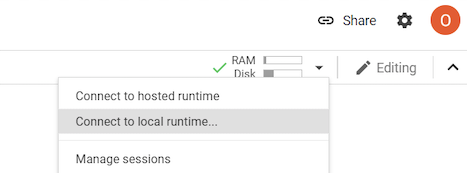

Having connected to the EPI2ME Labs Server, before anything else we will create and set a working directory:

In [ ]:
from epi2melabs import ping
pinger = ping.Pingu()
pinger.send_notebook_ping('start', 'metagenome')

# create a work directory and move into it
tutorial_name = "metagenome_tutorial"
working_dir = '/epi2melabs/{}/'.format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

/epi2melabs/metagenome_tutorial


### Sample Data

To demonstrate the workflow below a sample dataset is included with this tutorial. The data comprise an extract of a MinION run using the [ZymoBIOMICS](https://www.zymoresearch.com/collections/zymobiomics-microbial-community-standards) microbial mock community.

To download the sample dataset we run the `linux` command `wget`. To execute the command click on the cell and then press Command/Ctrl-Enter, or click the Play symbol to the left-hand side.

In [ ]:
bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
domain = "s3-eu-west-1.amazonaws.com"
site = "https://{}.{}".format(bucket, domain)

!wget -O sample.fastq.gz "$site/metagenomic_tutorial/sample.fastq.gz"

--2020-06-08 14:24:25--  https://ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com/metagenomic_tutorial/sample.fastq.gz
Resolving ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com (ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com)... 52.218.36.155
Connecting to ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com (ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com)|52.218.36.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119559772 (114M) [binary/octet-stream]
Saving to: ‘sample.fastq.gz’

sample.fastq.gz     100%[===================>] 114.02M  4.45MB/s    in 27s     

2020-06-08 14:24:52 (4.25 MB/s) - ‘sample.fastq.gz’ saved [119559772/119559772]



### Using your own data

If you have your own sequencing, you can edit the value of the input variables below in the **Data Entry** section. To find the correct full path of a file you can navigate to it in the **Files** browser to the left-hand side, right-click on the file and select **Copy path**:

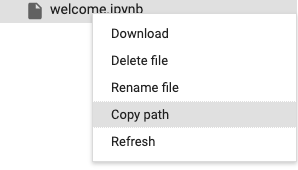

The location shared with the EPI2ME labs server from your computer will show as `/epi2melabs`, for example a file located at `/data/my_gridion_run/fastq_pass` on your computer will appear as `/epi2melabs/my_gridion_run/fastq_pass` when it is the `/data` folder that is shared.

### Data entry

Having downloaded the sample sequencing data, or locating your own data in the file browser, we need to provide the filepaths as input to the notebook. We must also select or download a metagenomic index.

The form can be used to enter the filenames of your inputs. Alternatively you can edit the code which reads the inputs by first double clicking the form header. After entering your inputs (or editing the code cell) remember to execute the code using `Command/Ctrl-Enter`, or pressing the `Play` symbol to the left-hand side.


In [ ]:
#@markdown **Select sequencing inputs:**
from glob import glob
import os
import shutil


#@markdown Enter the paths to your input files. The input data may be either a a single fastq, compressed or otherwise, file or a directory containing multiple such files:
input_data = "sample.fastq.gz" #@param {type:"string"}
output_folder = "analysis" #@param {type:"string"}
threads =  8#@param {type:"integer"}
input_file = os.path.join(output_folder, "input.fastq.gz")
!echo "* Making output folder"
!mkdir -p "$output_folder"
!echo "+ Consolidating input files"
!rationalise_fastq -i "$input_data" -o "$input_file"
print()

* Making output folder
+ Consolidating input files
Input: /epi2melabs/metagenome_tutorial/sample.fastq.gz
Output: /epi2melabs/metagenome_tutorial/analysis/input.fastq.gz
Output exists, exiting



To prepare a database use the form below. First select from the first dropdown whether to (download and) use a pre-made index or use an index present on your computer. Having made this selection fill in the requisite portion of the form before pressing `Play`.

In [ ]:
#@markdown **Select options for loading an index:**
#@markdown Choose an option from the dropdown and then further options below.
index_option = "Download" #@param ["Download", "Custom"]

#@markdown ***Either***: download/use pre-made index 
download_index = "Human+viruses+prokaryotes (inc. SARS-CoV-2)" #@param ["Human+viruses (inc. SARS-CoV-2)", "Human+viruses+prokaryotes (inc. SARS-CoV-2)"]

#@markdown ***Or***: use custom, directory containing index files
custom_location = "my-database" #@param {type:"string"}

bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
domain = "s3-eu-west-1.amazonaws.com"
site = "https://{}.{}".format(bucket, domain)

db_store = "db_store"
!mkdir -p "$db_store"
indices = {
    "Human+viruses (inc. SARS-CoV-2)": "hvc",
    "Human+viruses+prokaryotes (inc. SARS-CoV-2)": "hpvc"}
selected_database = None

if index_option == 'Custom':
    try:
        index1 = glob(os.path.join(custom_location, "*.1.cf"))
        if len(index1) == 1:
            index1, _, _ = index1[0].rpartition(".1.cf")
            print("* Found database {}.".format(index1))
            selected_database = os.path.abspath(index1)
    except:
        print("* Could not determine database under {}.".format(custom_location))
elif index_option == 'Download':
    print("* Downloading/checking index.")
    prefix = indices[download_index]
    if not os.path.exists(
            os.path.join(db_store, prefix, "{}.1.cf".format(prefix))):
        print("+ Downloading {} index.".format(download_index))
        !cd "$db_store" && wget -O "$prefix".tar.gz "$site"/metagenomic_tutorial/"$prefix".tar.gz
        !cd "$db_store" && mkdir -p "$prefix" && cd "$prefix" && tar -xvf ../"$prefix".tar.gz
    else:
        print("+ Found existing {} index.".format(download_index))
    selected_database = os.path.join(db_store, prefix, prefix)
else:
    print("* Invalid value for `index_option`.")

if selected_database is not None:
    dbpath = os.path.abspath(selected_database)    
    print("Selected database is: {}:".format(dbpath))
    !ls "$dbpath".*.cf


* Downloading/checking index.
+ Found existing Human+viruses+prokaryotes (inc. SARS-CoV-2) index.
Selected database is: /epi2melabs/metagenome_tutorial/db_store/hpvc/hpvc:
/epi2melabs/metagenome_tutorial/db_store/hpvc/hpvc.1.cf
/epi2melabs/metagenome_tutorial/db_store/hpvc/hpvc.2.cf
/epi2melabs/metagenome_tutorial/db_store/hpvc/hpvc.3.cf
/epi2melabs/metagenome_tutorial/db_store/hpvc/hpvc.4.cf


After running the above, a set of `.cf` files constituting the metagenomic database will be present in the location indicated. These files can used to perform single-read classifications using `centrifuge`.

### Inspecting the index

The centrifuge suite comes with a program to inspect a metagenomic index and summarize the data is contains. Here we will run the program to extract the total number of sequences in the selected database:


In [ ]:
!echo "Number of sequences in index: "
!centrifuge-inspect -n "$dbpath" | wc -l

Number of sequences in index: 
45959


## Metagenomic classification

In order to perform metagenomic classification of reads, the section below will use the `centrifuge` program together with the index selected or created above. We will then view the results of the classification using the `pavian` viewer.

### Running `centrifuge`

The first step in our analysis is to run `centrifuge` to classify all reads according to the selected index. Running the command below may take a fair amount of time depending on the compute resources available:

In [ ]:
!centrifuge -p $threads --met 5 --time --ignore-quals \
    -S analysis/read_classifications.tsv --report-file analysis/centrifuge_report.tsv \
    -x $dbpath -U $input_file

Time loading forward index: 00:00:15
Time loading reference: 00:00:00
Multiseed full-index search: 00:00:35
Time searching: 00:00:35
report file analysis/centrifuge_report.tsv
Number of iterations in EM algorithm: 0
Probability diff. (P - P_prev) in the last iteration: 0
Calculating abundance: 00:00:00
Overall time: 00:02:19


#### Identifying genera

The `centrifuge` program provides two primary outputs:

1.   `read_classifications.tsv`: a classification for each input read in terms of its origin.
2.   `centrifuge_report.tsv`: counts of reads for identified species.

The second of these can be used to identify the most common genera in the sample:

In [ ]:
import pandas as pd

d = pd.read_csv(os.path.join("analysis", "centrifuge_report.tsv"), sep='\t')
details = d['name'].str.split(n=1, expand=True)
details.columns = ['genus', 'epithet']
d = pd.concat([d, details], axis=1)
genus_id = d.groupby('genus') \
    .agg(numReads=('numReads', 'sum')) \
    .sort_values('numReads', ascending=False) \
    .reset_index()
read_filter = 1000
common_genera = sum(genus_id['numReads'] > read_filter)
print("{} genera identified with >{} reads.".format(common_genera, read_filter))
display(genus_id.head(8))

10 genera identified with >1000 reads.


,genus,numReads
0,Bacillus,57204
1,Staphylococcus,25309
2,Enterococcus,21647
3,Listeria,19076
4,Salmonella,18712
5,Escherichia,15102
6,Lactobacillus,8455
7,Pseudomonas,6376


### Viewing results with `pavian`

The [pavian](https://github.com/fbreitwieser/pavian) application can be used to visualise the results of a metagenomics classifer, including amonst other things producing Sankey diagrams.

In order to use `pavian` we must first convert the centrifuge report into a different format, this is done with the `centrifuge-kreport` program:

In [ ]:
!centrifuge-kreport -x $dbpath analysis/read_classifications.tsv \
    > analysis/read_classifications.tsv.kraken

Loading taxonomy ...
Loading names file ...
Loading nodes file ...


The `.kraken` file is what we must load into the `pavian` browser. The browser runs a webserver which can be started by running:

In [ ]:
#@markdown **Run `pavian` web application**

#@markdown Enter the auxiliary EPI2ME Labs port (from the EPI2ME Labs launcher)
port =  8889#@param {type:"integer"}

!R -e "pavian::runApp(host='0.0.0.0', port="$port")"
#!python -m http.server 9999


R version 3.4.4 (2018-03-15) -- "Someone to Lean On"
Copyright (C) 2018 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> pavian::runApp(host='0.0.0.0', port=8889)
Loading required package: shiny

Listening on http://0.0.0.0:8889
[Jun08 14:35] Started new shiny session #1 (1 session(s) running)
^C


The code cell above will run indefinitely until stopped by the user. In order to use `Pavian` click the link in the output above, displayed in the message: `Listening on http://0.0.0.0:8889`.

Once opened click on the **Use data on server** tab and then type `/epi2melabs` in the text entry box:

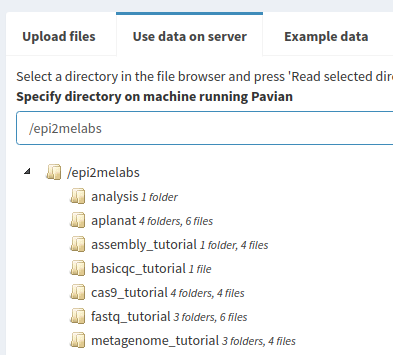

Then use the filebrowser to navigate to and select the `.kraken` report file produced above, and finally click **Read selected directories**:

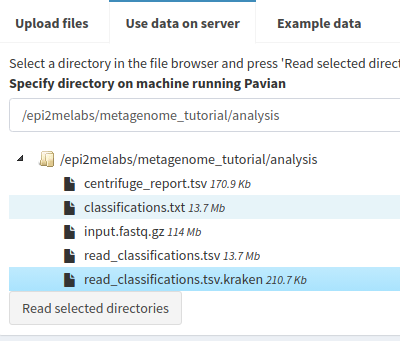

After selecting the dataset, Pavian can be used to explore the dataset. For example navigating to the **Sample** tab in the left-hand menu will display a Sankey plot visualising the classifications of reads. For example analysis of the sample dataset gives:

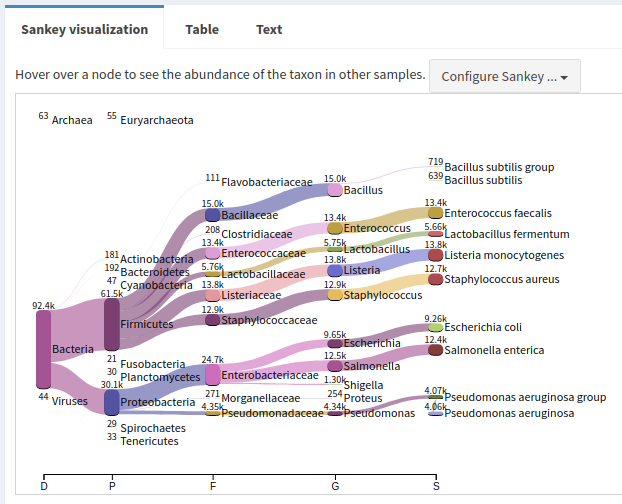

To generate a standalone report click the **Generate HTML report...** link in the left-hand menu. This will download a self-contained HTML file to your computer which summarises results of the analysis.

***When you have finished using Pavian, be sure to stop the code cell above which is running the Pavian webserver by clicking the `Stop` button to the left-hand side of the code cell.***

## Summary

This tutorial has step through the processes involved in classifying reads from a metagenomic sample and identifying the genera present. We have used `centrifuge-download` and `centrifuge-build` to create a metagenomic index from data available in the NCBI database, before using `centrifuge` to perform the classification. The results of the classification were inspected with the `pavian` viewer.

The analysis presented can be run on any dataset from an Oxford Nanopore Technologies' device. The code will run within **Google Colab** when connected to a local **EPI2ME Labs** notebook server.

[Back to EPI2ME Labs](https://colab.research.google.com/github/epi2me-labs/resources/blob/master/welcome.ipynb)
